Trigger time = 0.0s


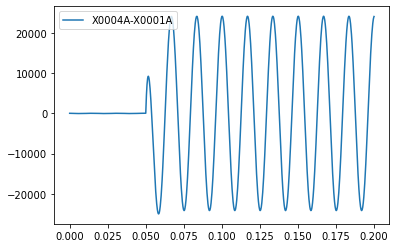

CG o alguna bifasica a tierra con Rf alto


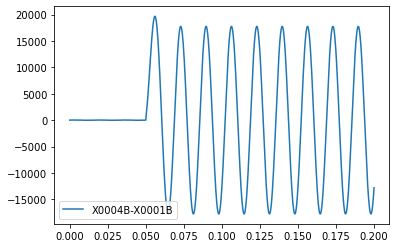

In [32]:
import matplotlib.pyplot as plt
from comtrade import Comtrade
import plotly.graph_objects as go
from antialising import Filtro
from array import array
from transformada import *
import secuencias
import numpy as np
import cmath

def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]


rec = Comtrade()
rec.load("sample_files/ATP_ABG.cfg", "sample_files/ATP_ABG.dat")
print("Trigger time = {}s".format(rec.trigger_time))

senal_I_a=0

senal_I_b=1

senal_I_c=2

senal_V_a=3

senal_V_b=4

senal_V_c=5

plt.figure()
plt.plot(rec.time, rec.analog[senal_I_a])
plt.legend([rec.analog_channel_ids[senal_I_a]])
plt.show()

def Windowing(senal_a,senal_b,senal_c,rec,I_nominal,I_sc3_min,V_a,V_b,V_c):
    data_a=rec.analog[senal_a]
    data_b=rec.analog[senal_b]
    data_c=rec.analog[senal_c]
    data_Va=rec.analog[V_a]
    data_Vb=rec.analog[V_b]
    data_Vc=rec.analog[V_c]
    t=rec.time
    fs = rec.cfg.sample_rates[0][0]       # sample rate 'analogo', Hz 
    fr=720#Frecuencia del relee
    r=(1/fr)//(1/fs)#Cantidad de muestras en 1 ciclo de una señal de 60Hz

    I_phase_r=np.empty((7,len(range(0,len(data_a),int(r)))))#[Ia;Ib;Ic;t;Va;Vb;Vc]

    for i in range(0,len(data_a),int(r)):#Creacion del array de muestras que toma el rele.
        I_phase_r[0][int(i/int(r))]=data_a[i]
        I_phase_r[1][int(i/int(r))]=data_b[i]
        I_phase_r[2][int(i/int(r))]=data_c[i]
        I_phase_r[3][int(i/int(r))]=t[i]
        I_phase_r[4][int(i/int(r))]=data_Va[i]
        I_phase_r[5][int(i/int(r))]=data_Vb[i]
        I_phase_r[6][int(i/int(r))]=data_Vc[i]
    s=1#numero de ciclos por ventana
    w=int(s*fr/60)#numero de muestras por ventana
  
    last_msg="Sin falla"#ultimo mensaje leido
    n=0#Cantidades sucesivas que se ha leido ese mensaje. Con 6 ventanas sucesivas (medio ciclo) reportando la misma falla, se activa el mecanismo de deteccion de fase fallada.
    k=0
    Keep=True
    while(w+k<=len(I_phase_r[3]) and Keep):
        I_a=Espectro(I_phase_r[0][k:w+k],fr)
        I_b=Espectro(I_phase_r[1][k:w+k],fr)
        I_c=Espectro(I_phase_r[2][k:w+k],fr)
        k+=1
        Seq=secuencias.seq(I_a,I_b,I_c)

        I0=Seq.item((0,0))
        I1=Seq.item((1,0))
        I2=Seq.item((2,0))
       
        msg=Evaluar(I0,I1,I2,I_nominal,I_sc3_min)

        if msg=="Sin falla":
            n=0
        elif msg==last_msg:
            n+=1
        else:
            last_msg=msg
            n=1
            
        if n==6:
            Keep=False
            v_a=Espectro(I_phase_r[4][k:w+k],fr)
            v_b=Espectro(I_phase_r[5][k:w+k],fr)
            v_c=Espectro(I_phase_r[6][k:w+k],fr)
            DefinePhase(last_msg,I_a,I_b,I_c,v_a,v_b,v_c)

def DefinePhase(msg,Ia,Ib,Ic,Va,Vb,Vc):
    if msg=="Falla BG o AC":
        MHO_BG=abs(Vb/Ib)
        MHO_AC=abs((Va-Vc)/(Ia-Ic))
        if MHO_BG>=MHO_AC:
            print("Falla AC")
        else:
            print("Falla BG")
    elif msg=="CG o alguna bifasica a tierra con Rf alto":
        pass

def Evaluar(I0,I1,I2,I_nominal,I_sc3_min):
    if(np.abs(I0)<0.6*I_nominal and np.abs(I2)<0.6*I_nominal and np.abs(I1)>=I_sc3_min):
            return "Falla trifasica"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)-90)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-150)%360):
            return "Falla BG o AC"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)+30)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-30)%360):
            return "Falla AG o BC"
    elif((np.angle(I2,True))%360<=(np.angle(I0,True)+150)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+90)%360):
            return "Falla CG o BA"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)+60)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+30)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)-30)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-60)%360))):
            return "AG o alguna bifasica a tierra con Rf alto"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)-60)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-90)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)-150)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)-180)%360))):
            return "BG o alguna bifasica a tierra con Rf alto"
    elif(((np.angle(I2,True))%360<=(np.angle(I0,True)+90)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+60)%360) or (((np.angle(I2,True))%360<=(np.angle(I0,True)+180)%360 and (np.angle(I2,True))%360>=(np.angle(I0,True)+150)%360))):
            return "CG o alguna bifasica a tierra con Rf alto"
    else:
            return "Sin falla"

def Espectro(data,fs):
    #Filtro pasa bajas
    cutoff = (fs-60)/3      # desired cutoff frequency of the filter, Hz
    order = 2

    y=Filtro(fs,order,cutoff,data)
    
    #Transformada
    N=len(data)
    Tf=1/fs
    SOL=FFT(y)
    SOL_f=FFT_f(N,Tf)

    SOL_abs=2.0/N * np.abs(SOL[0:N//2])
    SOL_angle=np.angle(SOL)[0:N//2]
    i=closest(SOL_f,60)
    j=np.where(SOL_f==i)#Index con el fasor de 60Hz
    #plt.polar([0,SOL_angle[j]],[0,SOL_abs[j]],marker='.')
    return cmath.rect(SOL_abs[j],SOL_angle[j])

I_nominal=33
I_sc3_min=200

Windowing(senal_I_a,senal_I_b,senal_I_c,rec,I_nominal,I_sc3_min,senal_V_a,senal_V_b,senal_V_c)
plt.figure()
plt.plot(rec.time,rec.analog[1])
plt.legend([rec.analog_channel_ids[1]])
plt.show()

In [32]:
np.angle((1-1j), deg=True)%360

315.0